In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.metrics import mean_squared_error
import csv
import lightgbm as lgb
from sklearn.preprocessing import LabelEncoder
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from scipy.stats import pearsonr

In [59]:
df = pd.read_csv('data(days).csv')
df['days'] = pd.to_datetime(df['days'], format='%Y-%m-%d')
df['Year-Week'] = df['days'].dt.strftime('%Y-%U')
df = df.drop('days',axis=1)
df = df.groupby(['CategoryName','Year-Week'])['total_sales'].sum()
df = pd.DataFrame(df,columns=['total_sales'])
df = df.reset_index()

In [60]:
df = df.sort_values(by=['CategoryName', 'Year-Week'])

In [61]:
df['prev_week_sales'] = df.groupby('CategoryName')['total_sales'].shift(1)
df_ = df.copy()
df

,CategoryName,Year-Week,total_sales,prev_week_sales
0,Beverages,2018-05,71242.0,NaN
1,Beverages,2018-06,596255.0,71242.0
2,Beverages,2018-07,565444.0,596255.0
3,Beverages,2018-08,682273.5,565444.0
4,Beverages,2018-09,341663.5,682273.5
...,...,...,...,...
1539,Seafood,2021-34,295423.0,269631.0
1540,Seafood,2021-35,216061.0,295423.0
1541,Seafood,2021-36,231179.0,216061.0
1542,Seafood,2021-37,208426.0,231179.0


In [62]:
df = df.dropna(subset=['prev_week_sales'])

In [63]:
df = df.drop(columns=['Year-Week'])

In [64]:
df

,CategoryName,total_sales,prev_week_sales
1,Beverages,596255.0,71242.0
2,Beverages,565444.0,596255.0
3,Beverages,682273.5,565444.0
4,Beverages,341663.5,682273.5
5,Beverages,462239.0,341663.5
...,...,...,...
1539,Seafood,295423.0,269631.0
1540,Seafood,216061.0,295423.0
1541,Seafood,231179.0,216061.0
1542,Seafood,208426.0,231179.0


In [65]:
label_encoder = LabelEncoder()
df['CategoryName'] = label_encoder.fit_transform(df['CategoryName'])

In [66]:
X = df.drop(columns=['total_sales'])
y = df['total_sales']

In [67]:
X.sample(40)

,CategoryName,prev_week_sales
403,2,397681.00
976,5,313690.00
309,1,324943.00
1426,7,265248.00
21,0,589520.00
1259,6,94361.00
919,4,200467.00
410,2,363355.00
252,1,264286.00
100,0,522168.00


In [68]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [69]:
models = {
    'Linear Regression': LinearRegression(),
    'Ridge Regression': Ridge(),
    'Lasso Regression': Lasso(),
    'Random Forest Regression': RandomForestRegressor(),
    'LightGBM': lgb.LGBMRegressor()
}

In [70]:
cv_results = {}
pearson_results = {}

cv_folds = 5

In [71]:
for name, model in models.items():
    pipeline = make_pipeline(StandardScaler(), model)
    
    pipeline.fit(X_train, y_train)
    
    y_pred = pipeline.predict(X_test)
    
    pearson_corr, _ = pearsonr(y_test, y_pred)
    pearson_results[name] = pearson_corr
    
    scores = cross_val_score(pipeline, X, y, cv=cv_folds, scoring='neg_mean_squared_error')
    mse_scores = -scores
    cv_results[name] = {
        'Mean MSE': np.mean(mse_scores),
        'Standard Deviation': np.std(mse_scores)
    }

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000029 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 264
[LightGBM] [Info] Number of data points in the train set: 1228, number of used features: 2
[LightGBM] [Info] Start training from score 297501.252564
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000033 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 263
[LightGBM] [Info] Number of data points in the train set: 1228, number of used features: 2
[LightGBM] [Info] Start training from score 268433.630236
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000028 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 263
[LightGBM] [Info] Number of data points in the train set: 1229, number of used features: 2
[LightGBM] [Info] Start tr

In [72]:
for name, results in cv_results.items():
    print(f'{name} - Mean MSE: {results["Mean MSE"]:.2f}, Standard Deviation: {results["Standard Deviation"]:.2f}')

print("\nPearson Correlation Coefficients:")
for name, pearson_corr in pearson_results.items():
    print(f'{name}: {pearson_corr:.4f}')

Linear Regression - Mean MSE: 5628918250.89, Standard Deviation: 2414577561.61
Ridge Regression - Mean MSE: 5629940742.19, Standard Deviation: 2414661180.15
Lasso Regression - Mean MSE: 5628993875.22, Standard Deviation: 2414582081.30
Random Forest Regression - Mean MSE: 10218891439.08, Standard Deviation: 7301227430.06
LightGBM - Mean MSE: 8854402529.31, Standard Deviation: 7819042599.18

Pearson Correlation Coefficients:
Linear Regression: 0.7601
Ridge Regression: 0.7601
Lasso Regression: 0.7601
Random Forest Regression: 0.7393
LightGBM: 0.8077


In [73]:
label_encoder = LabelEncoder()
df_['CategoryName'] = label_encoder.fit_transform(df_['CategoryName'])

In [75]:
df_

,CategoryName,Year-Week,total_sales,prev_week_sales
0,0,2018-05,71242.0,NaN
1,0,2018-06,596255.0,71242.0
2,0,2018-07,565444.0,596255.0
3,0,2018-08,682273.5,565444.0
4,0,2018-09,341663.5,682273.5
...,...,...,...,...
1539,7,2021-34,295423.0,269631.0
1540,7,2021-35,216061.0,295423.0
1541,7,2021-36,231179.0,216061.0
1542,7,2021-37,208426.0,231179.0


In [80]:
df_.dtypes

CategoryName         int32
Year-Week           object
total_sales        float64
prev_week_sales    float64
dtype: object

In [93]:
df_['date'] = pd.to_datetime(df_['Year-Week'] + '0', format='%Y-%W%w')
df_ = df_.drop('Year-Week',axis=1)
df_

,CategoryName,total_sales,prev_week_sales,Date_Time,date,year_numeric,season
0,0,71242.0,NaN,2018-02-04,2018-02-04,1,4
1,0,596255.0,71242.0,2018-02-11,2018-02-11,1,4
2,0,565444.0,596255.0,2018-02-18,2018-02-18,1,4
3,0,682273.5,565444.0,2018-02-25,2018-02-25,1,4
4,0,341663.5,682273.5,2018-03-04,2018-03-04,1,1
...,...,...,...,...,...,...,...
1539,7,295423.0,269631.0,2021-08-29,2021-08-29,4,2
1540,7,216061.0,295423.0,2021-09-05,2021-09-05,4,3
1541,7,231179.0,216061.0,2021-09-12,2021-09-12,4,3
1542,7,208426.0,231179.0,2021-09-19,2021-09-19,4,3


In [94]:
df_['year_numeric'] = df_['date'].dt.year - 2017

def get_season(month):
    if month in [3, 4, 5]:
        return 1  # 봄
    elif month in [6, 7, 8]:
        return 2  # 여름
    elif month in [9, 10, 11]:
        return 3  # 가을
    else:
        return 4  # 겨울

df_['season'] = df_['date'].dt.month.apply(get_season)

In [95]:
X_ = df_.drop(columns=['total_sales', 'date'])
y_ = df_['total_sales']

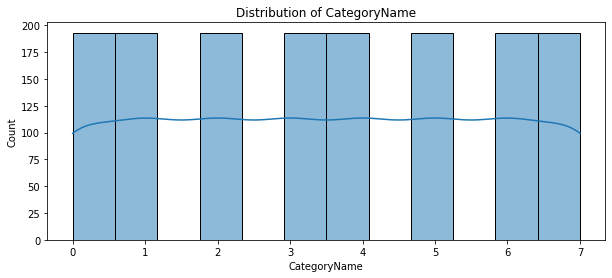

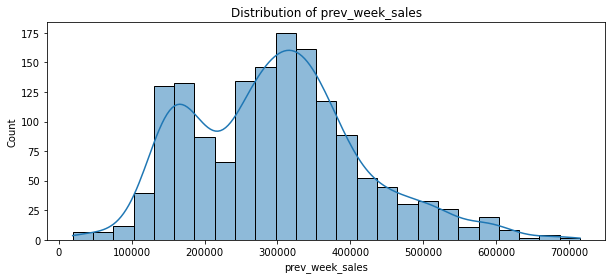

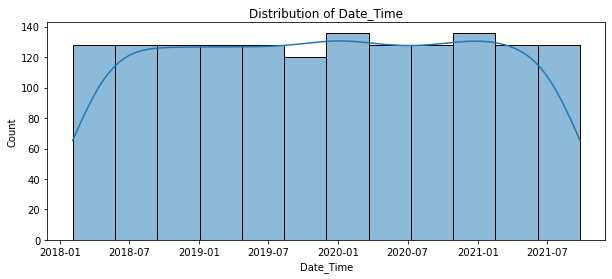

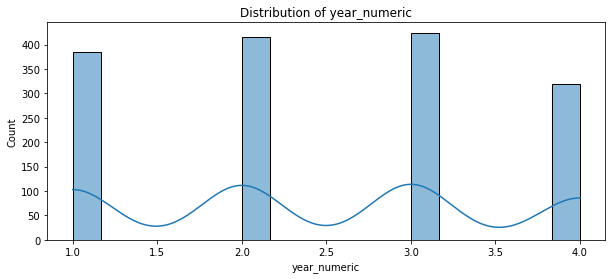

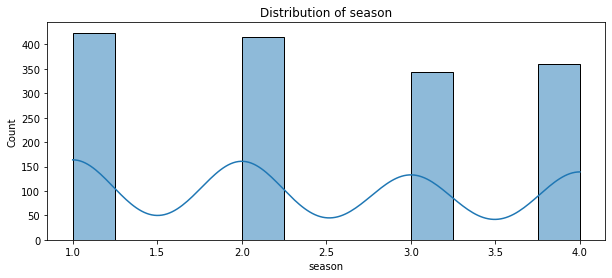

In [96]:
#변수의 분포 확인
for column in X_.columns:
    plt.figure(figsize=(10, 4))
    sns.histplot(X_[column], kde=True)
    plt.title(f'Distribution of {column}')
    plt.show()

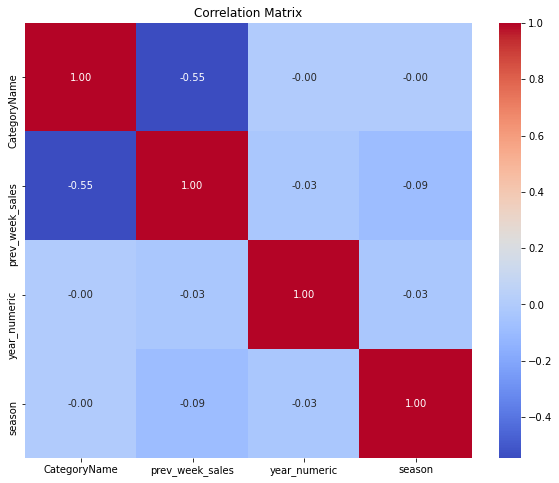

In [97]:
#히트맵
correlation_matrix = X_.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix')
plt.show()

In [92]:
#변수 선택 및 중요도

model_ = RandomForestRegressor()
model_.fit(X_, y_)

importances = model_.feature_importances_
indices = np.argsort(importances)[::-1]

plt.figure(figsize=(10, 6))
plt.title('Feature Importances')
plt.bar(range(X_.shape[1]), importances[indices], align='center')
plt.xticks(range(X_.shape[1]), X_.columns[indices], rotation=90)
plt.xlim([-1, X_.shape[1]])
plt.show()

ValueError: could not convert string to float: '2018-05'